In [254]:
# General imports
import numpy as np

# Pre-defined operator class for Hamiltonian
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# Specific imports for ground state energy calculation
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD, UCC

# To be used in performing simulations
from qiskit_ibm_runtime import Session

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit_aer import AerSimulator
aer_sim = AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_nature.second_q.operators.commutators import commutator


# from qiskit_aer.primitives import EstimatorV2 as Estimator 
from qiskit.primitives import Estimator

from qiskit.circuit.library import EvolvedOperatorAnsatz
import scipy

In [255]:

def cost_func(params, ansatz, hamiltonian, estimator):
 
    # pub = (ansatz, hamiltonian, params)
    # result = estimator.run(pubs=[pub]).result()
    # energy = result[0].data.evs[0]

    # pub = (ansatz, hamiltonian, params)
    # job = estimator.run([pub])
    # result = job.result()
    # pub_result = result[0]
    # energy = float(pub_result.data.evs)

    job = estimator.run([ansatz], [hamiltonian], [params])
    energy = job.result().values[0]

    # job = estimator.run(ansatz, hamiltonian, params)
    # energy = job.result().values[0]

    # cost_history_dict["iters"] += 1
    # cost_history_dict["prev_vector"] = params
    # cost_history_dict["cost_history"].append(energy)
    # print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

estimator  = Estimator()



/tmp/ipykernel_979963/2768237559.py:26: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator  = Estimator()


In [278]:
#molecule information
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.712; H 0 0 2.712; H 0 0 3.424",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)
es_problem = driver.run()
hamiltonian = es_problem.hamiltonian
coefficients = hamiltonian.electronic_integrals
second_q_op = hamiltonian.second_q_op()
mapper = JordanWignerMapper()
qubit_op = mapper.map(second_q_op)

constant_energy = es_problem.hamiltonian.constants
nuc_rep_energy = list(constant_energy.values())

In [279]:
# generate commutator operators 
ansatz = UCCSD(es_problem.num_spatial_orbitals, 
               es_problem.num_particles, mapper,  generalized = True,
              )
comms = []
for i in range(0,len(ansatz.operators)):
    
    comm = commutator(qubit_op,ansatz.operators[i])*(1.0j)
    comm = (sum(comm,comm.adjoint())/2)
    comm = comm.simplify()
    comms.append(comm)

In [280]:
def optimization(ansatz, operator, params):
    
    res = scipy.optimize.minimize(

        cost_func,
        params,
        args=(ansatz, operator,estimator),
        method="SLSQP",
    )

    return res.fun, res.x

In [281]:
def comp_commutator(ansatz, hamiltonian, params):
    job = estimator.run([ansatz], [hamiltonian], [params])
    energy = job.result().values[0]
    return energy

In [ ]:
n = 10  # number of cycle
eps = 10**(-5) # convergence threshold
exc_ops = []
energies = []
norm = []
for i in range(0,n):
    if i == 0:

        psi0 = HartreeFock(es_problem.num_spatial_orbitals, 
                              es_problem.num_particles, 
                              mapper)
        grad_vec = []
        for j in range(0, len(comms)):

            job = estimator.run([psi0], [comms[j]])
            grad = job.result().values[0]
            # print(grad)
            grad_vec.append(grad)
        
        
        grad_vec = np.absolute(np.round(grad_vec, 5))
        index = np.where(grad_vec == max(grad_vec))
        exc_ops.append(index[0][0])
        psi = psi0.copy()
        psi = psi.compose(EvolvedOperatorAnsatz(ansatz.operators[index[0][0]], parameter_prefix='t'+str(i)+''))

        x = [0]*psi.num_parameters

        opt_energy = optimization(psi, qubit_op, x)
        # print(opt_energy[0])
        energies.append(opt_energy[0]) 
        # print(opt_energy[1])
        x_new = opt_energy[1]
        grad_norm = np.dot(grad_vec, grad_vec)
        norm.append(grad_norm)
    
    else:    
        
        
        print(grad_norm)
        if grad_norm > eps:
            grad_vec = []
            for j in range(0, len(comms)):
                grad = comp_commutator(psi,comms[j],x_new)
                grad_vec.append(grad)

            grad_vec = np.absolute(np.round(grad_vec, 5))
            index = np.where(grad_vec == max(grad_vec))
            exc_ops.append(index[0][0])
            psi = psi.compose(EvolvedOperatorAnsatz(ansatz.operators[index[0][0]], parameter_prefix='t'+str(i)+''))

            x = [0]*psi.num_parameters

            opt_energy = optimization(psi, qubit_op, x)
            # print(opt_energy[0]) 
            energies.append(opt_energy[0]) 
            # print(opt_energy[1])
            x_new = opt_energy[1]
            grad_norm = np.dot(grad_vec, grad_vec)
            norm.append(grad_norm)  

        if grad_norm < eps:
            break

energies = energies + nuc_rep_energy[0]

0.2614265403
0.23260610510000004
0.1945921651
0.1598711687
0.1070868679
0.087092052
0.0575354044
0.0332916493
2.28573e-05


In [283]:
print(energies)

[-2.2378394  -2.24316367 -2.24856111 -2.25515323 -2.25943799 -2.26335244
 -2.26729083 -2.27185028 -2.27185194 -2.27185381]


In [285]:
import pyscf
from pyscf import gto, scf
mol = gto.M(atom='H 0 0 0; H 0 0 0.712; H 0 0 2.712; H 0 0 3.424', basis='sto-3g')
myhf = mol.RHF().run()
cisolver = pyscf.fci.FCI(myhf)
print('E(FCI) = %.12f' % cisolver.kernel()[0])


converged SCF energy = -2.23318331214816
E(FCI) = -2.271950242065


In [275]:
print(exc_ops)

[np.int64(34), np.int64(23), np.int64(38), np.int64(27), np.int64(20), np.int64(41), np.int64(28), np.int64(33), np.int64(4), np.int64(10)]


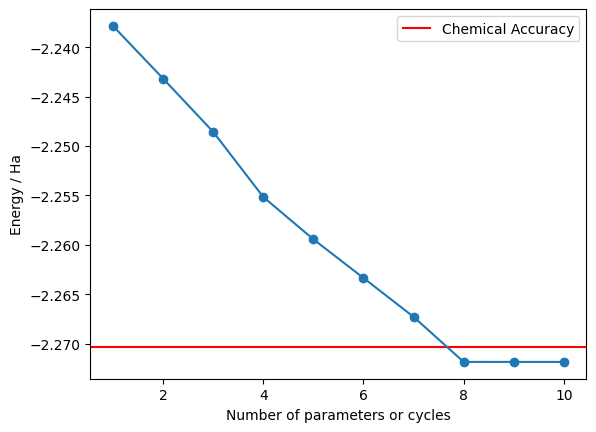

In [287]:
import matplotlib.pyplot as plt
x = np.arange(1, len(energies)+1, 1)
plt.axhline(y = cisolver.kernel()[0] + 0.0016, color = 'red', linestyle = '-', label = 'Chemical Accuracy')
plt.plot(x, energies, marker = 'o')
plt.xlabel('Number of parameters or cycles')
plt.ylabel('Energy / Ha')
# plt.axhline(y = -2.217027768639, color = 'r', linestyle = '-', label = 'FCI')
# plt.ylim(-2.22, -2.188)
plt.legend()
# plt.vlines(-2.217027768639)

/tmp/ipykernel_979963/1035702736.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


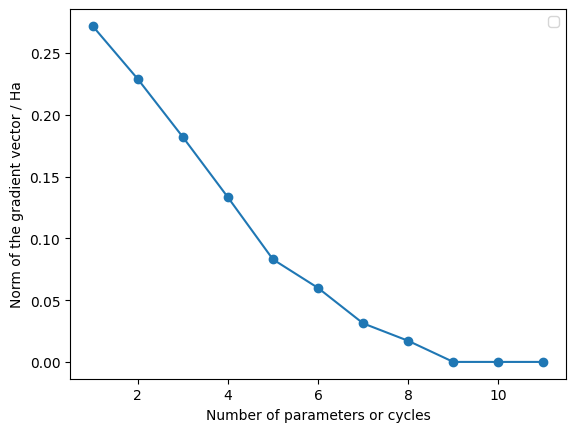

In [277]:
import matplotlib.pyplot as plt
x = np.arange(1, len(norm)+1, 1)
# plt.axhline(y = -2.217027768639 + 0.0016, color = 'red', linestyle = '-', label = 'Chemical Accuracy')
plt.plot(x, norm, marker = 'o')
plt.xlabel('Number of parameters or cycles')
plt.ylabel('Norm of the gradient vector / Ha')
# plt.axhline(y = -2.217027768639, color = 'r', linestyle = '-', label = 'FCI')
# plt.ylim(-2.22, -2.188)
plt.legend()
# plt.vlines(-2.217027768639)